## Feature Examination ADNI dataset

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy

In [2]:
import seaborn as sns

### Build the ADNI training dataset
I need to load the core spreadsheet, and load the extra spreadsheet where required
Then I need to match the IDs. THen we have a spreadsheet that we can fit a logistic regression model with

In [214]:
save_folder = "ADNI_feature_plots/"

In [3]:
ADNI_core_df = pd.read_csv("/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/ADNI/clinscore_data.csv")

In [4]:
uncertainty_type="ssn_ens"

In [5]:
uncertainty_type

'ssn_ens'

In [6]:
def load_model_output_stats(output_type, threshold, fields=None):
    df = pd.read_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/ADNI/{uncertainty_type}_{output_type}_{threshold}.csv")
    if fields != None:
        return df[fields]
    return df

In [7]:
ent03 = load_model_output_stats("ent", 0.3)

In [8]:
def merge_datasets(core_df, output_types, thresholds, selected_fields):
    for output_type, thresh, fields in zip(output_types, thresholds, selected_fields):
        
        extra_df = load_model_output_stats(output_type, thresh, fields) # load the specific output type at the given threshold, and select the desired fields
        
        extra_df['Patient ID'] = ["_".join(full_id.split("_")[1:4]) for full_id in extra_df['ID']] # create the patient ID column that matches the information from the main clinscore dataframe
        extra_df = extra_df.drop(columns='ID')
        # print(extra_df['Patient ID'].values)
        extra_df = extra_df.rename(columns={key: f"{output_type}{thresh}_{key}" if key != 'Patient ID' else 'Patient ID' for key in extra_df.keys()}) # modify the column name so that we know which columns belong to which input type
        
        # print(len(core_df))
        core_df = core_df.merge(extra_df, on="Patient ID")
        
    
    core_df = core_df.drop(columns='Patient ID')       
    
    return core_df

In [9]:
all_image_extracted_fields = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',]

pred_values = ['seg_volume', 'vent_volume']

### Add the sample diversity data

In [10]:
if uncertainty_type != "deterministic":
    data_folder = f"/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/{uncertainty_type}/"
    all_data_files = os.listdir(data_folder)
    sample_div_files = [f for f in all_data_files if "sample_div" in f and "CHAL" not in f]

    dfs = [pd.read_csv(data_folder + f) for f in sample_div_files]

    sample_div_df = pd.concat(dfs)
    
    sample_div_df['Patient ID'] = ["_".join(full_id.split("_")[1:4]) for full_id in sample_div_df['ID']] # create the patient ID column that matches the information from the main clinscore dataframe
    sample_div_df = sample_div_df.drop(columns='ID')
    #sample_div_df.drop(columns='Unnamed: 0')
    
    ADNI_core_df = ADNI_core_df.merge(sample_div_df, on="Patient ID")
    

### Explore how base features vary with Fazekas (and what the class balance is)

In [11]:
sns.set_style("whitegrid")
# plt.style.use('fivethirtyeight')

In [12]:
def get_uniques(df, key):
    values = df[key].values
    uniques = np.unique(values)
    uniques = uniques[np.logical_not(np.isnan(uniques))] # remove nan, if it is there
    return uniques

In [13]:
def simple_hist_bar_plot(ax, df, key, xlabel, color='#1cdaeb'):
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=0)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=0)
    classes = get_uniques(df, key)
    values = df[key].values
    counts = [0 for _ in range(len(classes))]
    for i, c in enumerate(classes):
        counts[i] = np.sum(values == c)
    ax.bar(classes, counts, zorder=2, color=color); # zorder 2 is above grid but below axis (3 puts it above the axis
    if xlabel == None:
        xlabel = key
    ax.set_xlabel(xlabel)
    ax.set_ylabel("count")
    ax.set_xticks(classes)
    ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
    ax.spines[['left', 'bottom']].set_linewidth(1.1) # make the left and bottom spines thicker#
    ax.spines[['left', 'bottom']].set_color('#585858')

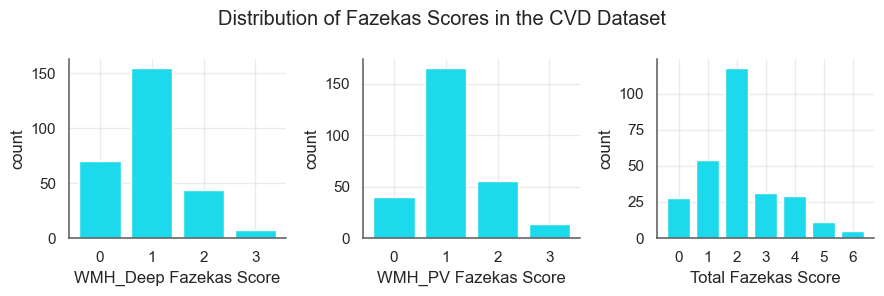

In [371]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
simple_hist_bar_plot(axs[0], ADNI_core_df, 'WMH_Deep', 'WMH_Deep Fazekas Score')
simple_hist_bar_plot(axs[1], ADNI_core_df, 'WMH_PV', 'WMH_PV Fazekas Score')
simple_hist_bar_plot(axs[2], ADNI_core_df, 'Total', 'Total Fazekas Score')
plt.suptitle("Distribution of Fazekas Scores in the CVD Dataset")
plt.savefig(save_folder+"fazekas_distribution.pdf", bbox_inches="tight")
fig.tight_layout()

### How does predicted WMH volume predict fazekas score?

In [345]:
def get_palette(x):
    if x == "WMH_Deep":
        palette = sns.color_palette("YlOrBr", 4)
    elif x == "WMH_PV":
        palette = sns.color_palette("YlGn", 4)
    else:
        palette = sns.color_palette("Purples", 7)
        
    return palette

In [346]:
def simple_box_plot(ax, df, x, y, xlabel=None, ylabel=None, logy=False, logx=False, ylim=None, no_y_axis=False, title=None):
    
    palette = get_palette(x)
    
    ax = sns.boxplot(data=df, x=x, y=y, ax=ax, hue=x, legend=None, palette=dict([(v, palette[int(v)]) for v in df[x].unique()]))
    if xlabel == None:
        xlabel = x
    if ylabel == None:
        ylabel = y
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
    ax.spines[['left', 'bottom']].set_linewidth(1.1) # make the left and bottom spines thicker#
    #ax.spines[['left', 'bottom']].set_color('#585858')
    
    if no_y_axis:
        ax.tick_params(left=False, labelleft=False)
        ax.spines[['left']].set_visible(False)
    
    # give a thicker spine.
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Adjust thickness as desired
    
    if logy:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')
        
    if ylim:
        ax.set_ylim(ylim)
    
    if title:
        ax.set_title(title)

In [347]:
import matplotlib.patheffects as PathEffects
def simple_scatter_plot(ax, df, x, y, hue=None, xlabel=None, ylabel=None, logy=False, logx=False, legend_title=None, no_y_axis=True):
    palette = get_palette(hue)
    ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=dict([(v, palette[int(v)]) for v in df[hue].unique()]))
    if xlabel == None:
        xlabel = x
    if ylabel == None:
        ylabel = y
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
    ax.spines[['left', 'bottom']].set_linewidth(2) # make the left and bottom spines thicker#
    # ax.spines[['left', 'bottom']].set_color('#585858')
    if logy:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')
    print(get_uniques(df, hue))
    plt.legend(loc='lower right', title=legend_title)
    
    if no_y_axis:
        ax.tick_params(left=False, labelleft=False)
        ax.spines[['left']].set_visible(False)
    
    ### adding the pearson correlation coefficient to the plot
    xs = df[x]
    ys = df[y]
    if logx:
        xs = np.log(xs.values)
    if logy:
        ys = np.log(ys.values)
    
    r = scipy.stats.pearsonr(df[x], df[y])[0]
    if r < 0.48:
        xalign = 0.95
        halign="right"
    else:
        xalign=0.05
        halign="left"
    
    # Add text in top right corner
    txt = ax.text(xalign, 0.95, fr'$r={r:.2f}$', 
            verticalalignment='top', 
            horizontalalignment=halign,
            transform=ax.transAxes,
            fontsize=12) 
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

In [348]:
added_inputs = ["pred", "ent", "ent", "ent", "ent", "ent", "pred", "pred", "pred", "pred", "var"]
thresholds = [0.5, 0.1, 0.3, 0.2, 0.4, 0.45, 0.1, 0.3, 0.5, 0.6, 0.06]
# added_fields = [['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean'], ['kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg'], ['kurtosis']]
added_fields = [pred_values, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields]
added_fields = [f+['ID'] for f in added_fields]

included_terms = [0, 1,2,3,4,5,6, 7, 8, 9]#0]#, 2]#, 1]#, 3]
added_inputs = [added_inputs[idx] for idx in included_terms]
thresholds = [thresholds[idx] for idx in included_terms]
added_fields = [added_fields[idx] for idx in included_terms]

core_fields = ADNI_core_df.keys()

In [349]:
combined_df = merge_datasets(ADNI_core_df[core_fields], added_inputs, thresholds, added_fields)
combined_df['Total'] = combined_df['Total'].astype('int32')

In [350]:
combined_df['WMH_PV'] = combined_df['WMH_PV'].astype(int)
combined_df['WMH_Deep'] = combined_df['WMH_Deep'].astype(int)

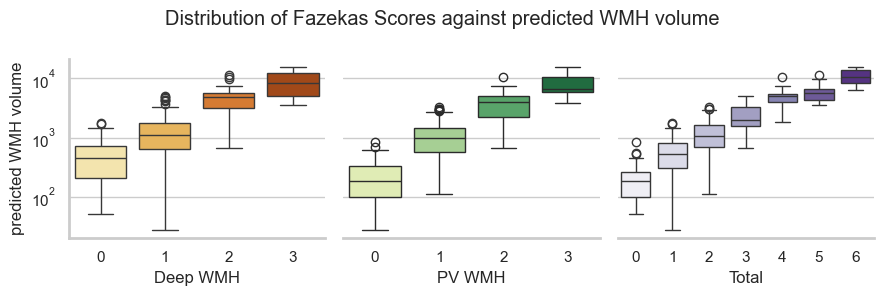

In [372]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
simple_box_plot(axs[0], combined_df, x='WMH_Deep', y='pred0.5_seg_volume', xlabel="Deep WMH", ylabel="predicted WMH volume", logy=True)
simple_box_plot(axs[1], combined_df, x='WMH_PV', y='pred0.5_seg_volume', xlabel="PV WMH", ylabel="", logy=True, no_y_axis=True)
simple_box_plot(axs[2], combined_df, x='Total', y='pred0.5_seg_volume', xlabel='Total', ylabel="", logy=True, no_y_axis=True)
plt.suptitle("Distribution of Fazekas Scores against predicted WMH volume")
plt.savefig(save_folder+"predicted volme vs fazekas.pdf", bbox_inches="tight")
fig.tight_layout()

### examine how each feature distributes with volume and fazekas category (WMH_PV, WMH_Deep, Total, then GT predicted WMH volume)
dice, lesion f1, avd, sample_div_std, sample_div_IQR, sample_div_skew, and vd equivalents

In [373]:
def quad_fazekas_comparison_plot_box(df, y, ylabel, kind='box', logy=False, log_scatter_y=True, scatter_hue="WMH_Deep"):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    simple_box_plot(axs[0], df, x='WMH_Deep', y=y, xlabel="Deep WMH", ylabel=ylabel, logy=logy)
    simple_box_plot(axs[1], df, x='WMH_PV', y=y, xlabel="PV WMH", ylabel="", logy=logy, no_y_axis=True)
    simple_box_plot(axs[2], df, x='Total', y=y, xlabel='Total', ylabel="", logy=logy, no_y_axis=True)
    simple_scatter_plot(axs[3], df, x='pred0.5_seg_volume', y=y, hue=scatter_hue, xlabel="predicted WMH volume", ylabel="", logy=logy, logx=log_scatter_y, legend_title="DWMH" if "d" in scatter_hue.lower() else "PVWMH", no_y_axis=True)
    if ylabel == None:
        ylabel = y
    plt.suptitle(f"Comparing ({ylabel}) with Fazekas")
    fig.tight_layout()
    plt.savefig(save_folder+f"{uncertainty_type}_{y}_featureplot.pdf", bbox_inches="tight")
    
    

[0 1 2 3]


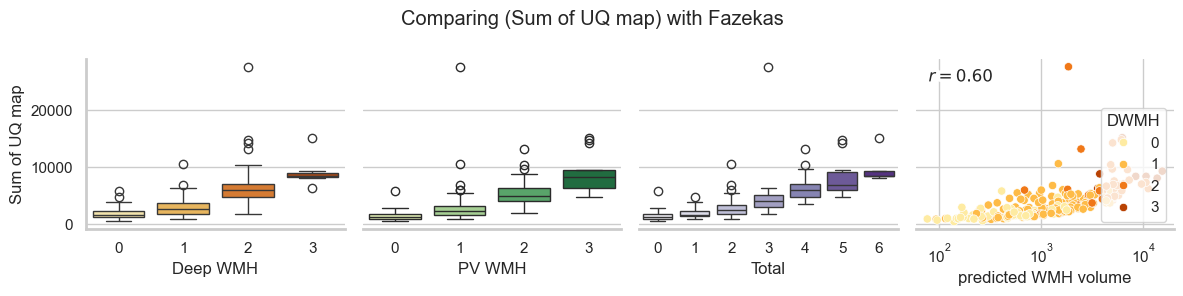

In [374]:
quad_fazekas_comparison_plot_box(combined_df.dropna(), y=f'ent0.1_sum', ylabel="Sum of UQ map")

[0 1 2 3]


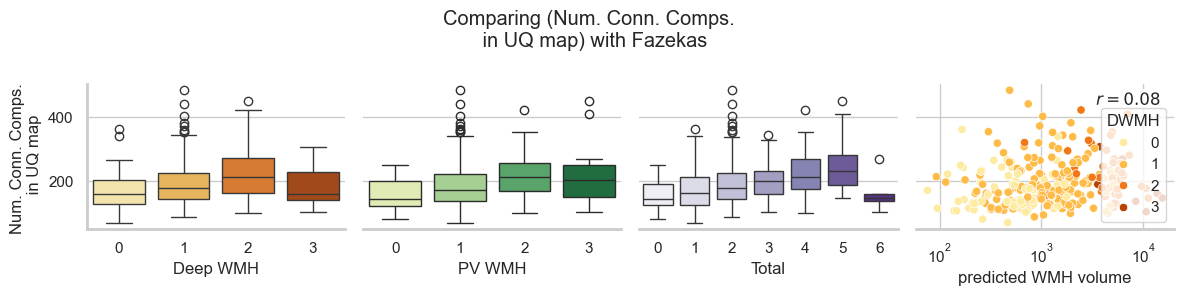

In [375]:
quad_fazekas_comparison_plot_box(combined_df.dropna(), y=f'ent0.1_cc_num', ylabel="Num. Conn. Comps. \n in UQ map")

[0 1 2 3]


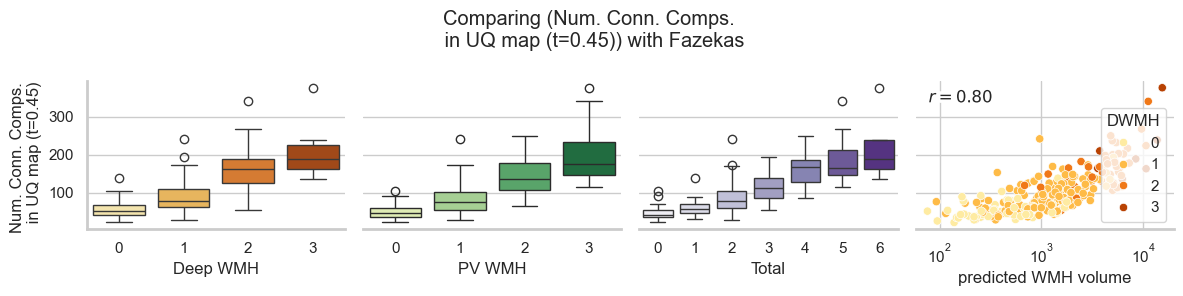

In [376]:
quad_fazekas_comparison_plot_box(combined_df.dropna(), y=f'ent0.45_cc_num', ylabel="Num. Conn. Comps. \n in UQ map (t=0.45)")

[0 1 2 3]


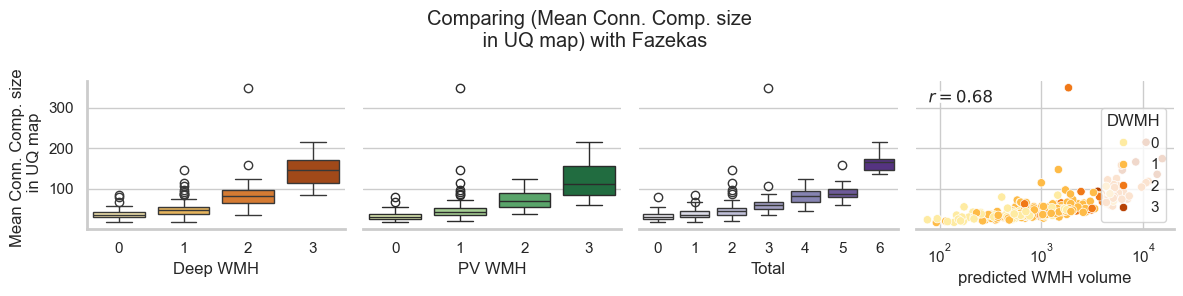

In [377]:
quad_fazekas_comparison_plot_box(combined_df.dropna(), y=f'ent0.1_cc_size_mean', ylabel="Mean Conn. Comp. size \n in UQ map")

[0 1 2 3]


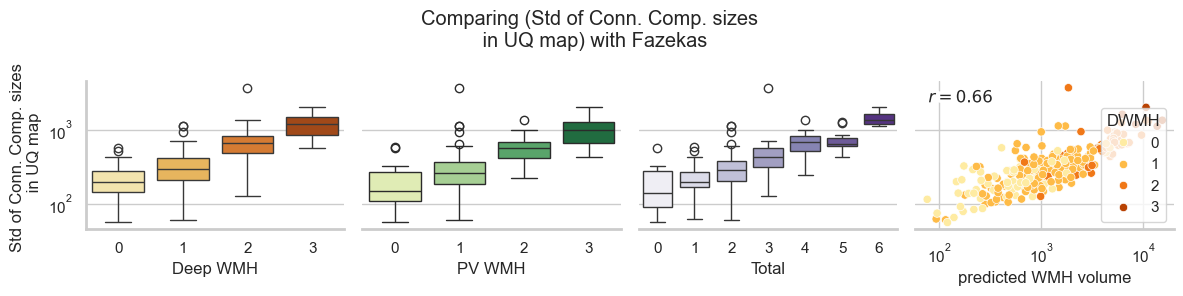

In [378]:
quad_fazekas_comparison_plot_box(combined_df.dropna(), logy=True, y=f'ent0.1_cc_size_std', ylabel="Std of Conn. Comp. sizes \n in UQ map")

[0 1 2 3]


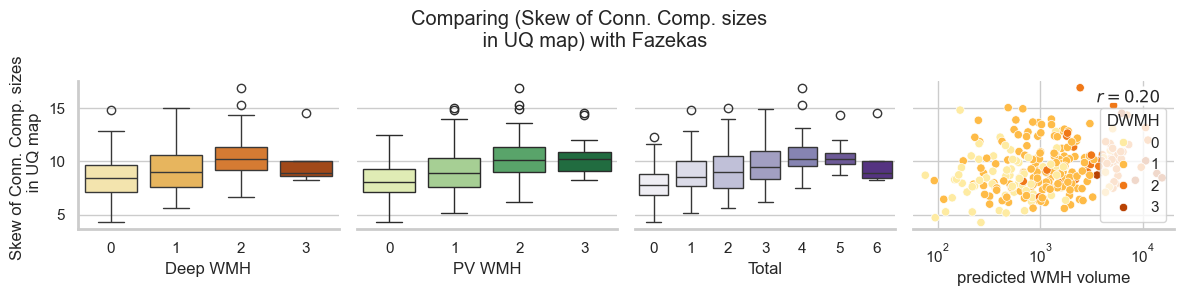

In [379]:
quad_fazekas_comparison_plot_box(combined_df.dropna(), y=f'ent0.1_cc_size_skew', ylabel="Skew of Conn. Comp. sizes \n in UQ map")

[0 1 2 3]


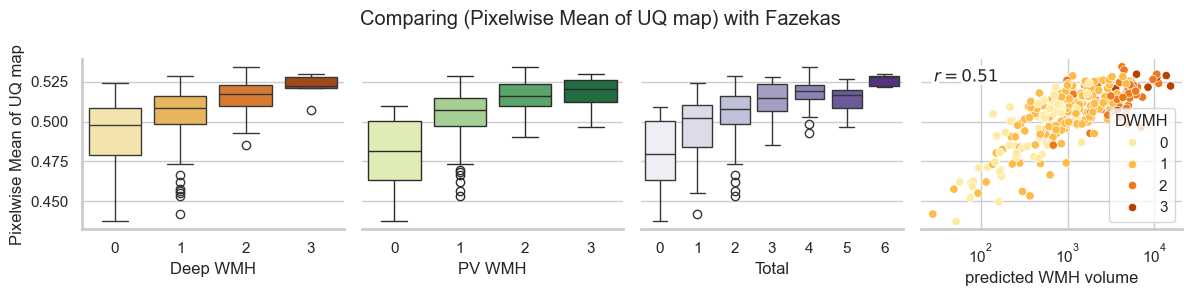

In [380]:
quad_fazekas_comparison_plot_box(combined_df, y=f'ent0.3_mean', ylabel="Pixelwise Mean of UQ map")

[0 1 2 3]


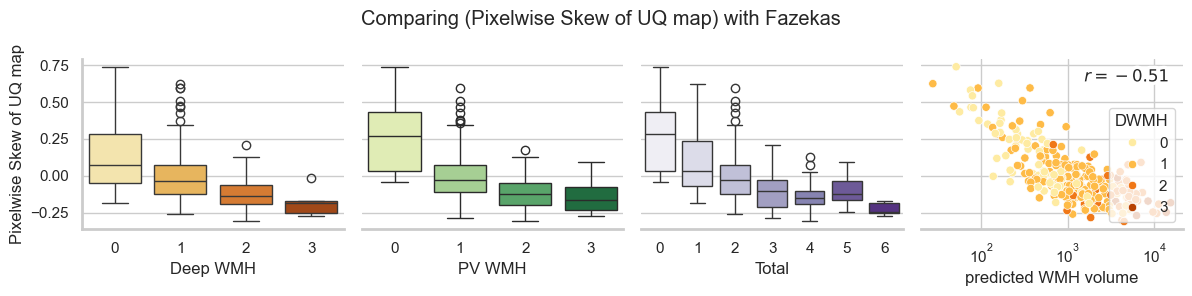

In [381]:
quad_fazekas_comparison_plot_box(combined_df, y=f'ent0.3_skew', ylabel="Pixelwise Skew of UQ map")

[0 1 2 3]


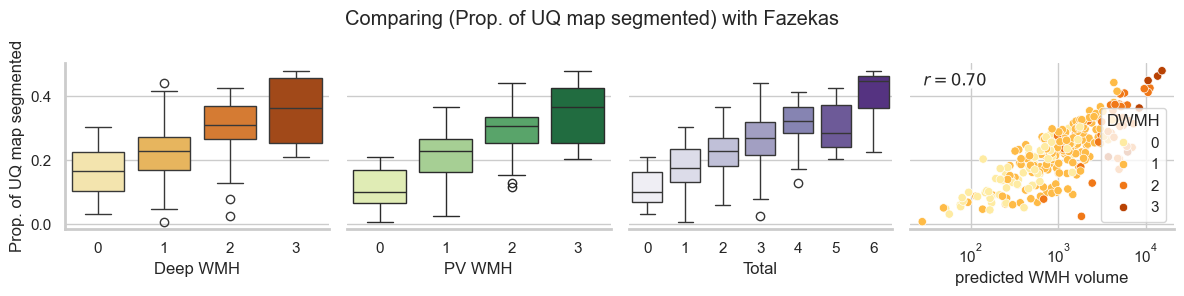

In [382]:
quad_fazekas_comparison_plot_box(combined_df, y=f'ent0.3_prop_umap_segmented', ylabel="Prop. of UQ map segmented")

[0 1 2 3]


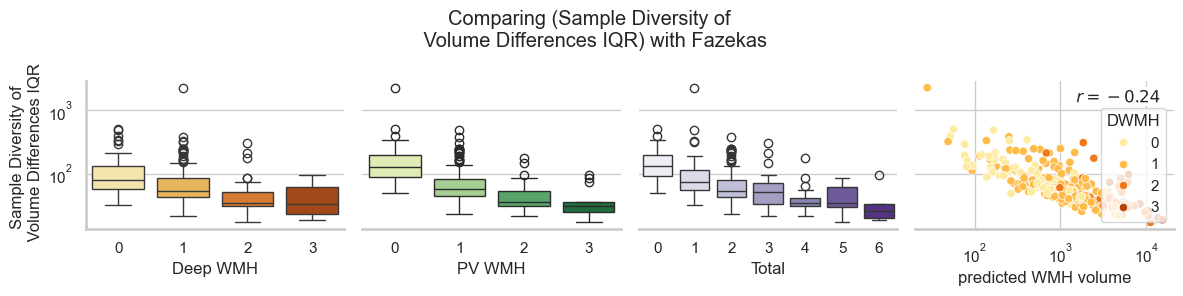

In [383]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_vd_IQR', ylabel='Sample Diversity of \n Volume Differences IQR', kind='box', logy=True)

[0 1 2 3]


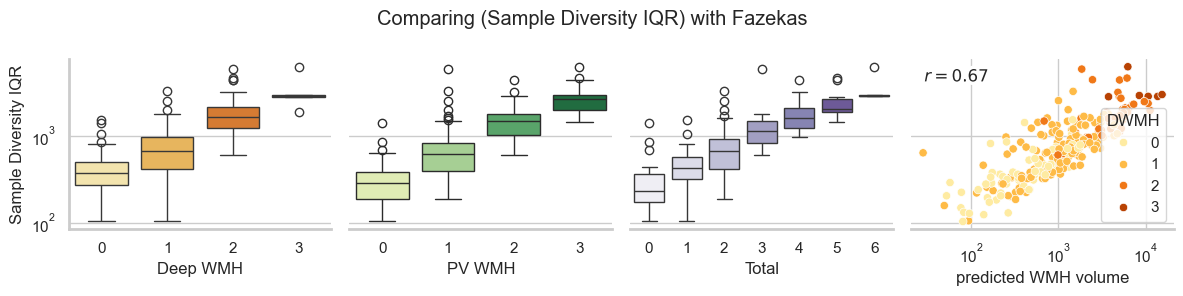

In [384]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_IQR', ylabel='Sample Diversity IQR', kind='box', logy=True)

### comparing with fixed dwmh, pvwmh

In [385]:
def compare_d_vs_pv_fixed_plots(df, y, ylabel=None, logy=False, log_scatter_y=True):
    fig, axs = plt.subplots(2, 4, figsize=(8, 6))
    ylim = (df[y].min(), df[y].max())
    simple_box_plot(axs[0,0], df.loc[df['WMH_PV'] == 0], x='WMH_Deep', y=y, xlabel="Deep WMH", ylabel=ylabel, logy=logy, ylim=ylim, title="PV WMH = 0")
    simple_box_plot(axs[0,1], df.loc[df['WMH_PV'] == 1], x='WMH_Deep', y=y, xlabel="Deep WMH", ylabel="", logy=logy, ylim=ylim, no_y_axis=True, title="PV WMH = 1")
    simple_box_plot(axs[0,2], df.loc[df['WMH_PV'] == 2], x='WMH_Deep', y=y, xlabel='Deep WMH', ylabel="", logy=logy, ylim=ylim, no_y_axis=True, title="PV WMH = 2")
    simple_box_plot(axs[0,3], df.loc[df['WMH_PV'] == 3], x='WMH_Deep', y=y, xlabel='Deep WMH', ylabel="", logy=logy, ylim=ylim, no_y_axis=True, title="PV WMH = 3")
    simple_box_plot(axs[1,0], df.loc[df['WMH_Deep'] == 0], x='WMH_PV', y=y, xlabel="PV WMH", ylabel=ylabel, logy=logy, ylim=ylim, title="Deep WMH = 0")
    simple_box_plot(axs[1,1], df.loc[df['WMH_Deep'] == 1], x='WMH_PV', y=y, xlabel="PV WMH", ylabel="", logy=logy, ylim=ylim, no_y_axis=True, title="Deep WMH = 1")
    simple_box_plot(axs[1,2], df.loc[df['WMH_Deep'] == 2], x='WMH_PV', y=y, xlabel='PV WMH', ylabel="", logy=logy, ylim=ylim, no_y_axis=True, title="Deep WMH = 2")
    simple_box_plot(axs[1,3], df.loc[df['WMH_Deep'] == 3], x='WMH_PV', y=y, xlabel='PV WMH', ylabel="", logy=logy, ylim=ylim, no_y_axis=True, title="Deep WMH = 3")
    plt.suptitle(f"Comparing ({ylabel}) with fixed Fazekas categories")
    fig.tight_layout()
    
    if not ylabel:
        ylabel = y
    
    plt.savefig(save_folder+f"{uncertainty_type}_{ylabel}_compared_fixed_featureplot.pdf", bbox_inches="tight")
    

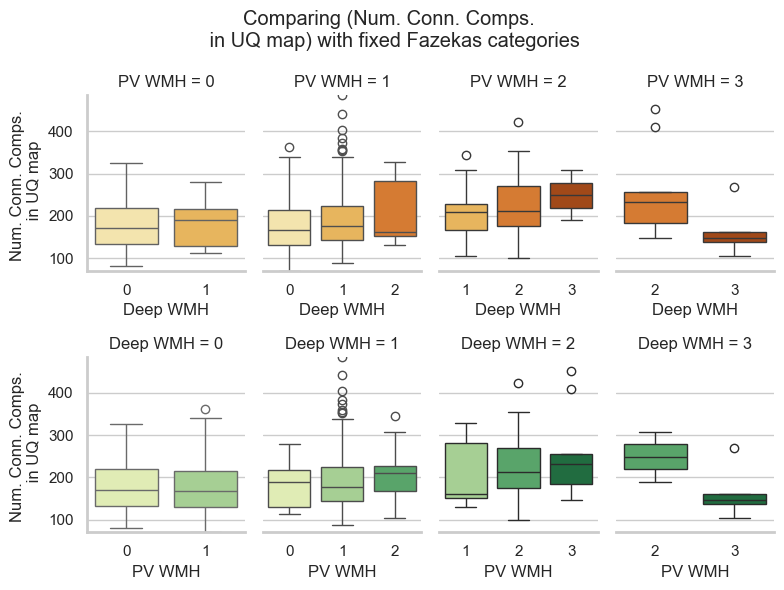

In [386]:
compare_d_vs_pv_fixed_plots(combined_df, y=f'ent0.1_cc_num', ylabel="Num. Conn. Comps. \n in UQ map", log_scatter_y=True)

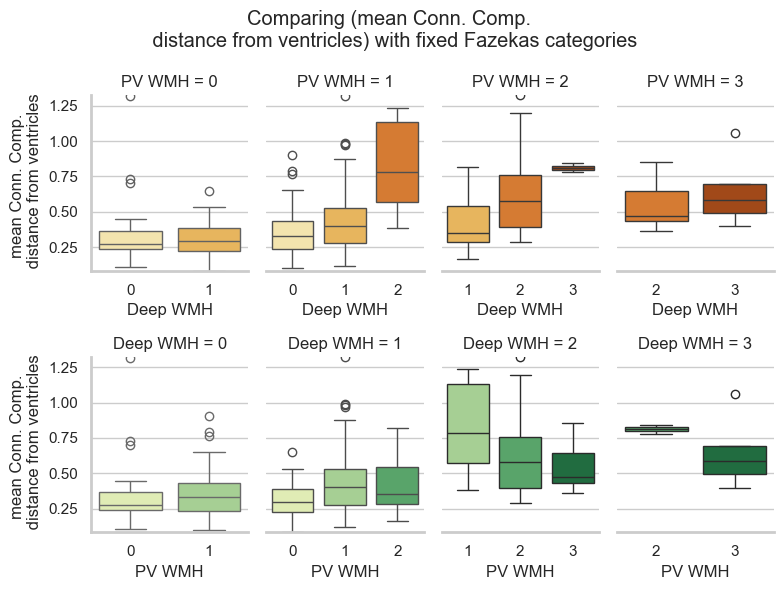

In [387]:
compare_d_vs_pv_fixed_plots(combined_df, y=f'ent0.3_cc_vd_mean', ylabel="mean Conn. Comp. \n distance from ventricles", log_scatter_y=True)

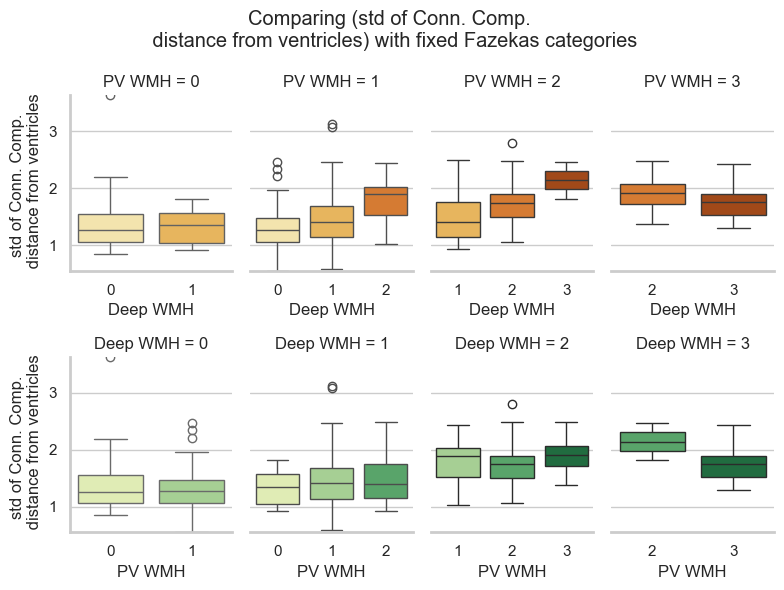

In [388]:
compare_d_vs_pv_fixed_plots(combined_df, y=f'ent0.1_cc_vd_std', ylabel="std of Conn. Comp. \n distance from ventricles", log_scatter_y=True)

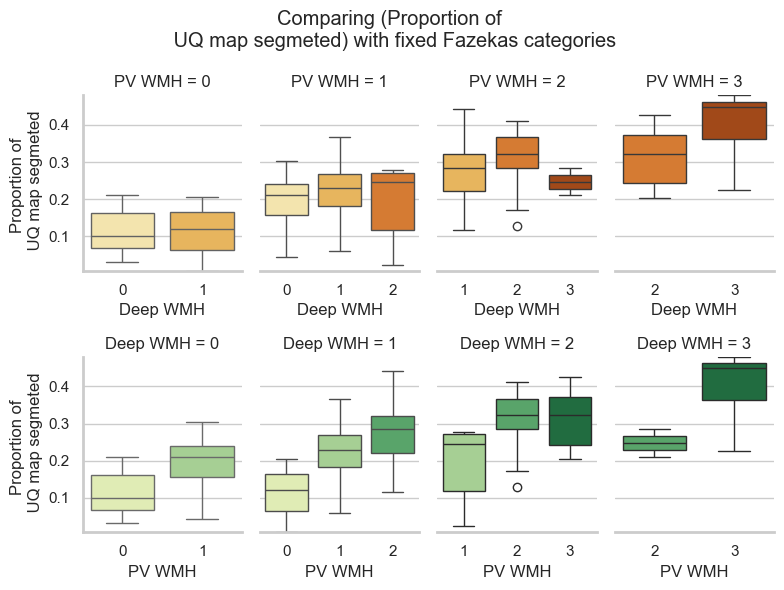

In [389]:
compare_d_vs_pv_fixed_plots(combined_df, y=f'ent0.3_prop_umap_segmented', ylabel="Proportion of \n UQ map segmeted", log_scatter_y=True)

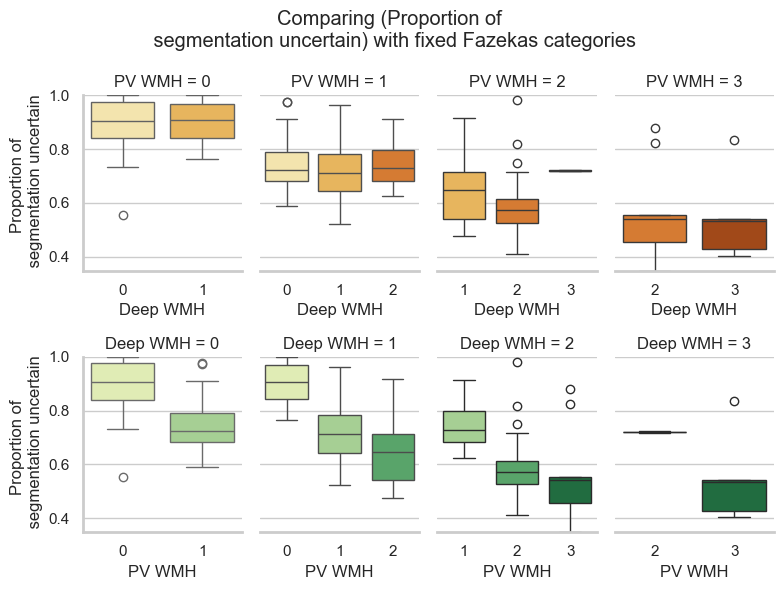

In [390]:
compare_d_vs_pv_fixed_plots(combined_df, y=f'ent0.3_prop_seg_uncertain', ylabel="Proportion of \n segmentation uncertain", log_scatter_y=True)

In [370]:
# eval = 0.3
# compare_fixed_fields = ['cc_vd_mean',
#        'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
#        'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 
#        ]

# for cat in compare_fixed_fields:
#     compare_d_vs_pv_fixed_plots(combined_df, y=f'ent{eval}_{cat}', ylabel=None, log_scatter_y=True)
    
    

In [225]:
ADNI_core_df.keys()

Index(['Unnamed: 0_x', 'Patient ID', 'AGE', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMI', 'WMH_PV', 'WMH_Deep', 'Total',
       'PTGENDER', 'E-M RISK FACTORS', 'DX.bl_0', 'DX.bl_1', 'DX.bl_2',
       'DX.bl_3', 'CV RISK FACTORS_0', 'CV RISK FACTORS_1',
       'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1', 'APOE4_2', 'totatal_fazekas',
       'Unnamed: 0_y', 'sample_div_std', 'sample_div_IQR', 'sample_div_skew',
       'sample_div_vd_std', 'sample_div_vd_IQR', 'sample_div_vd_skew'],
      dtype='object')

In [226]:
#quad_fazekas_comparison_plot_box(combined_df, y='AGE', ylabel='Age')

In [227]:
# combined_df['pred0.5_dist_mean'].values

In [228]:
all_image_extracted_fields = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',
       ]

pred_values = ['seg_volume', 'vent_volume']

### Global params

In [319]:
# for cat in all_image_extracted_fields:
#     quad_fazekas_comparison_plot_box(combined_df.dropna(), y=f'ent0.1_{cat}', ylabel=cat)
#     plt.show()
#     quad_fazekas_comparison_plot_box(combined_df.dropna(), y=f'ent0.3_{cat}', ylabel=cat)
#     plt.show()

### Sample Div params

[0 1 2 3]


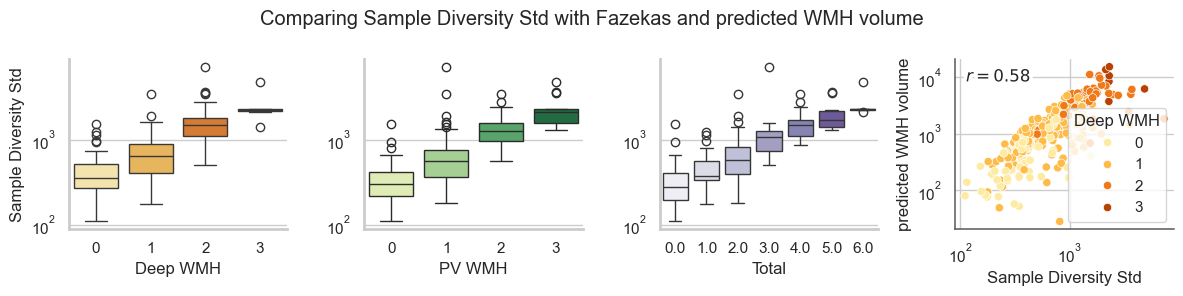

In [154]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_std', ylabel='Sample Diversity Std', kind='box', logy=True)

[0 1 2 3]


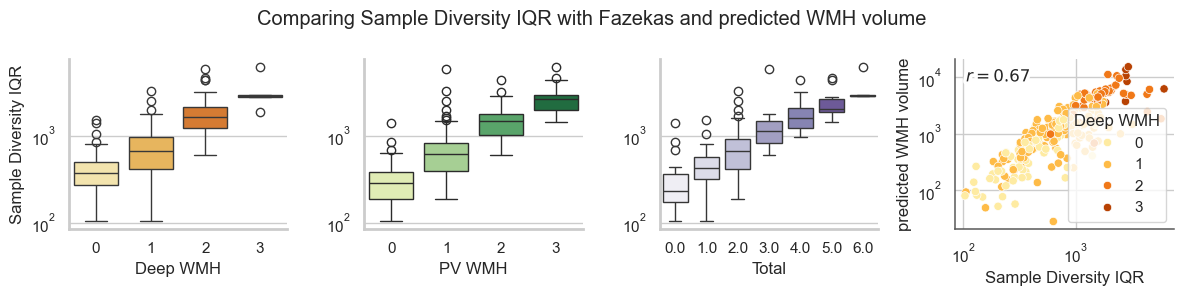

In [155]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_IQR', ylabel='Sample Diversity IQR', kind='box', logy=True)

[0 1 2 3]


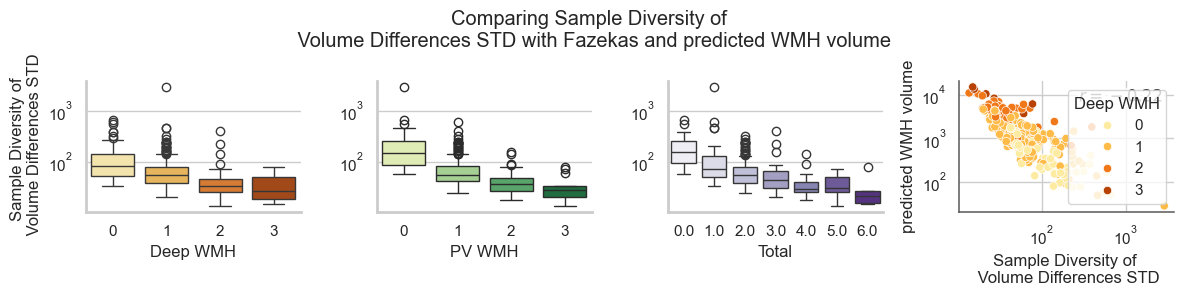

In [156]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_vd_std', ylabel='Sample Diversity of \n Volume Differences STD', kind='box', logy=True)

[0 1 2 3]


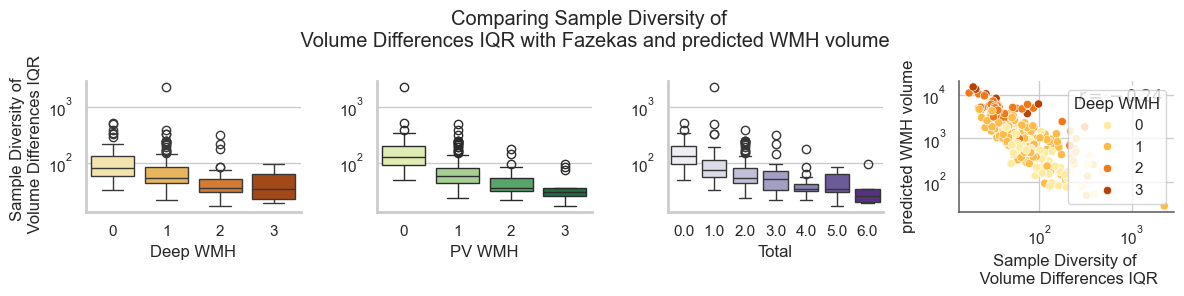

In [157]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_vd_IQR', ylabel='Sample Diversity of \n Volume Differences IQR', kind='box', logy=True)

[0 1 2 3]


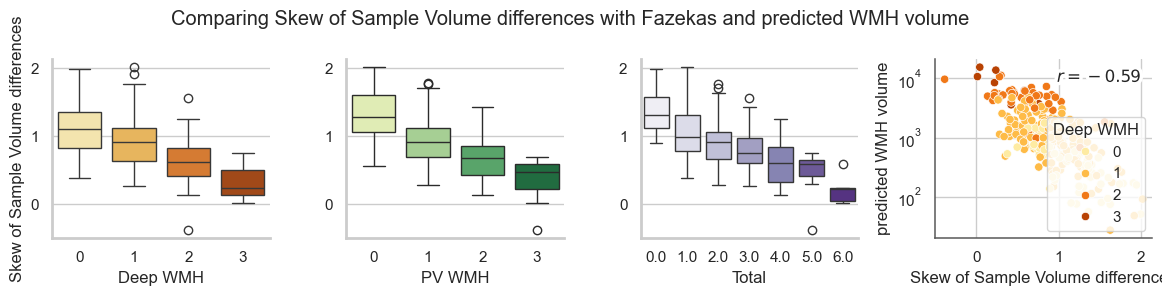

In [158]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_skew', ylabel='Skew of Sample Volume differences', kind='box')

### todo

- [x] figure out a more concise way to represent this data
- [x] fix the w ylims so that they match for each row of the plot
- [x] add titles for each figure.
- [x] fix the colours so that they are consistent, and so that DWMH, PVWMH and total fazekas use different colour schemes for each one.
- [x] make sure the colours for 0, 1, 2, 3 are consistent in the joint plots. Nice.
- [x] make sure the scatter plot follows the same colour scheme.
- [ ] add significance tests to the separation between each class for a more meaningful comparison
- [x] sort out the labels and the colors of each plot
- [ ] generate the plots for the CVD dataset as well!!
- [x] swap the axes on the scatter plot and then sort out the r label to match (make the white border transparent?)
- [x] (then I could remove the y-axis ticks - just have one y axis on the left and separate x axis for each plot. I like that.).
- [x] change the font and put a gray background to the plots and make the axis lines thicker so they look nicer.
- [x] get rid of the total fazekas for the comparison function (make a new function please for a 3 plot or 2 plot thing?)
- [x] use bard or chatgpt or something to help speed up each step please.
- [ ] go back and get the plots on sample diversity for P-Unet.
- [ ] put the plots in the overleaf
- [ ] put the new confusion matrices in the overleaf
- [ ] fix the captions for the new confusion matrices
- [ ] write the captions for the feature plots.

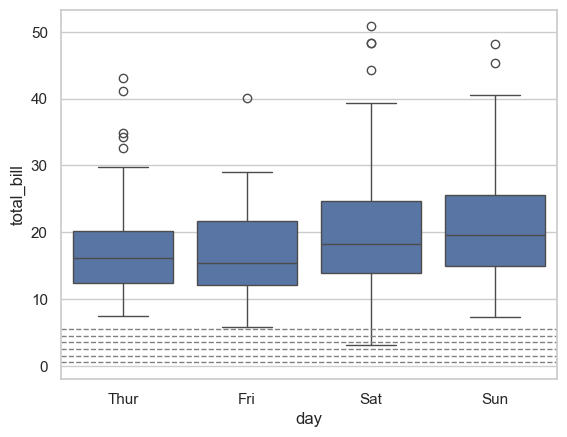

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create some example data
data = sns.load_dataset("tips")

# Create a boxplot
sns.set(style="whitegrid")
ax = sns.boxplot(x="day", y="total_bill", data=data)

# Add horizontal lines between rows
num_rows = len(ax.get_yticklabels())
for i in range(num_rows - 1):
    ax.axhline((i + 1) - 0.5, color='gray', linestyle='--', linewidth=1)

# Show the plot
plt.show()
